In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset,DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = "/content/drive/MyDrive/A-Z Dataset/A_Z Handwritten Data.csv.zip"

In [4]:
with ZipFile(zip_path) as zipfile:
    zipfile.extractall()

In [5]:
csv_path = "/content/A_Z Handwritten Data.csv"

In [6]:
df = pd.read_csv(csv_path)

In [8]:
df.shape

(372450, 785)

In [9]:
df.columns

Index(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9',
       ...
       '0.639', '0.640', '0.641', '0.642', '0.643', '0.644', '0.645', '0.646',
       '0.647', '0.648'],
      dtype='object', length=785)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: int64(785)
memory usage: 2.2 GB


In [11]:
X = df.drop('0',axis = 1).to_numpy() # axis=1 is to say to drop along the columns
y = df['0'].to_numpy()

In [12]:
X.shape

(372450, 784)

In [13]:
y.shape

(372450,)

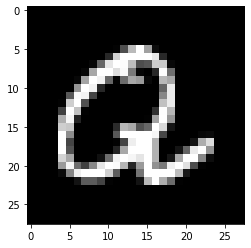

In [14]:
index = np.random.randint(0,372450)
plt.imshow(X[index].reshape(28,28),cmap="gray")

In [15]:
372450 * 0.2 # size of the testing data

74490.0

In [16]:
372450 - 74490 # size of the training data

297960

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [19]:
del df

In [20]:
X_train.shape,y_train.shape

((297960, 784), (297960,))

In [21]:
X_test.shape,y_test.shape

((74490, 784), (74490,))

In [22]:
297960 * 0.2 # val dataset size

59592.0

In [23]:
297960 - 59592 # training dataset size

238368

In [24]:
# now take some for validation
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

In [25]:
X_train.shape,X_val.shape

((238368, 784), (59592, 784))

In [26]:
y_train.shape,y_val.shape

((238368,), (59592,))

In [27]:
class Alphabets(Dataset):

  def __init__(self,X,y,transform=None):
    self.X = X
    self.y = y
    self.transform = transform
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,index):
    # np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((input_size, input_size)).convert('RGB'))

    image = Image.fromarray(((self.X[index]).astype(np.uint8)).reshape(28,28))
    label = self.y[index]

    if self.transform != None:
      image = self.transform(image)
    
    return image,label

In [28]:
transform = transforms.Compose([
         transforms.ToTensor(),
         transforms.RandomAffine(
                  degrees=30, translate=(0.5, 0.5), scale=(0.25, 1),
                  shear=(-30, 30, -30, 30)),                      
])

In [29]:
X_train.shape,X_test.shape,X_val.shape

((238368, 784), (74490, 784), (59592, 784))

In [30]:
y_train.shape,y_test.shape,y_val.shape

((238368,), (74490,), (59592,))

In [31]:
train_dataset = Alphabets(X_train,y_train,transform)
test_dataset = Alphabets(X_test,y_test,transform)
val_dataset = Alphabets(X_val,y_val,transform)

In [32]:
len(train_dataset),len(test_dataset),len(val_dataset)

(238368, 74490, 59592)

In [60]:
train_dataset_loader = DataLoader(train_dataset,batch_size=100,shuffle=True)
test_dataset_loader = DataLoader(test_dataset,batch_size=100,shuffle=True)
val_dataset_loader = DataLoader(val_dataset,batch_size=100,shuffle=True)

In [61]:
import torchvision

inputs_batch, labels_batch = next(iter(train_dataset_loader))
grid = torchvision.utils.make_grid(inputs_batch, nrow=40, pad_value=1)
torchvision.utils.save_image(grid, 'inputs_batch_preview.png')


<class 'list'>
2
100
100
torch.Size([100, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([100])
torch.Size([])
label ::  18


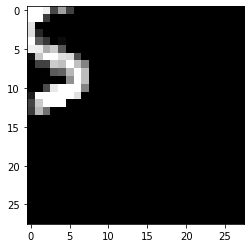

In [62]:
df = iter(train_dataset_loader)
df = next(df)

print(type(df))
print(len(df))

print(len(df[0]))
print(len(df[1]))

print(df[0].shape)
print(df[0][0].shape)

print(df[1].shape)
print(df[1][0].shape)


plt.imshow(df[0][0].reshape(28,28),cmap="gray")
print("label :: ",df[1][0].item())

In [63]:
config = [
     # input_channels:int,no.of filters:int,filter_size:int,stride:int,padding:int
     (1,16,3,1,1),
     # MP - max pooling:string,filter_size:int,stride:int,padding:int
     ("MP",2,2,0),
     (16,32,3,1,1),
     ("MP",2,2,0),
     (32,64,3,1,1),
     ("MP",2,2,0),
     (64,128,3,1,1),
     ("MP",2,2,0),
]

In [64]:
def conv_output_size(img_size,padding,filter_size,stride,n_filters):
   size_ = (int((img_size + (2 * padding) - filter_size) / stride)) + 1
   return size_,size_,n_filters

In [65]:
def dense_layer_size(configuration,img_size):

  _,output_channels = 0,0
  layer_count = 0

  for config in configuration:
    
    layer_count += 1

    if config[0] == "MP":
      img_size,_,output_channels = conv_output_size(img_size,config[3],config[1],config[2],output_channels)
      print("Max Pooling Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)

    else: 
      img_size,_,output_channels = conv_output_size(img_size,config[4],config[2],config[3],config[1])
      print("Conv Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)
  
  return img_size,_,output_channels

In [66]:
width,heigth,channels = dense_layer_size(config,28)

Conv Layer 1 output dims ::  28 28 16
Max Pooling Layer 2 output dims ::  14 14 16
Conv Layer 3 output dims ::  14 14 32
Max Pooling Layer 4 output dims ::  7 7 32
Conv Layer 5 output dims ::  7 7 64
Max Pooling Layer 6 output dims ::  3 3 64
Conv Layer 7 output dims ::  3 3 128
Max Pooling Layer 8 output dims ::  1 1 128


In [67]:
class NeuralNetwork(nn.Module):

  def __init__(self):
    super(NeuralNetwork,self).__init__()

    self.layer1 = nn.Sequential(
      nn.Conv2d(1,16,3,1,1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
    )

    self.layer2 = nn.Sequential(
      nn.Conv2d(16,32,3,1,1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
    )

    self.layer3 = nn.Sequential(
      nn.Conv2d(32,64,3,1,1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
    )

    self.layer4 = nn.Sequential(
      nn.Conv2d(64,128,3,1,1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
    )

    self.FC = nn.Sequential(
      nn.Linear(128,26)
    )


  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = torch.flatten(x,1)
    x = self.FC(x)

    return x



In [68]:
net = NeuralNetwork()
net.train()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): B

In [69]:
lr = 0.01
optim = torch.optim.Adam(net.parameters(),lr)
loss_fn = nn.CrossEntropyLoss()

In [71]:
epochs = 15

train_len = len(train_dataset_loader)
val_len = len(val_dataset_loader)

training_accuracy = []
training_loss = []

validation_accuracy = []
validation_loss = []

for epoch in range(epochs):

  epoch_acc = 0
  epoch_loss = 0

  for batch_id,(image,label) in enumerate(train_dataset_loader):

    output = net(image)

    loss = loss_fn(output,label)

    optim.zero_grad()
    loss.backward()
    optim.step()

    acc = (output.argmax(dim=1) == label).float().mean()
    epoch_acc += (acc.item() / len(train_dataset_loader)) 
    epoch_loss += (loss.item() / len(train_dataset_loader)) 
  
  print(f"Epoch :: [{epoch+1}/{epochs}] Train Accuracy :: {epoch_acc:.4f} Train Loss :: {epoch_loss:.4f}") 
  
  training_accuracy.append(epoch_acc)
  training_loss.append(epoch_loss)

  with torch.no_grad():

    epoch_val_accuracy = 0
    epoch_val_loss = 0
    
    for batch_id,(image, label) in enumerate(val_dataset_loader):
  
      val_output = net(image)
      val_loss = loss_fn(val_output,label)
      
      val_acc = ((val_output.argmax(dim=1) == label).float().mean())
      epoch_val_accuracy += (val_acc.item() / len(val_dataset_loader))  
      epoch_val_loss += (val_loss.item() / len(val_dataset_loader))

    print(f"Epoch :: [{epoch+1}/{epochs}] Val Accuracy :: {epoch_val_accuracy:.4f} Val Loss :: {epoch_val_loss:.4f}")

    validation_accuracy.append(epoch_val_accuracy)
    validation_loss.append(epoch_val_loss)
    

Epoch :: [1/15] Train Accuracy :: 0.6836 Train Loss :: 1.0355
Epoch :: [1/15] Val Accuracy :: 0.6878 Val Loss :: 1.0182
Epoch :: [2/15] Train Accuracy :: 0.6937 Train Loss :: 1.0020
Epoch :: [2/15] Val Accuracy :: 0.6916 Val Loss :: 1.0096
Epoch :: [3/15] Train Accuracy :: 0.6996 Train Loss :: 0.9784
Epoch :: [3/15] Val Accuracy :: 0.6993 Val Loss :: 0.9860
Epoch :: [4/15] Train Accuracy :: 0.7049 Train Loss :: 0.9607
Epoch :: [4/15] Val Accuracy :: 0.7060 Val Loss :: 0.9548
Epoch :: [5/15] Train Accuracy :: 0.7098 Train Loss :: 0.9453
Epoch :: [5/15] Val Accuracy :: 0.7088 Val Loss :: 0.9488
Epoch :: [6/15] Train Accuracy :: 0.7135 Train Loss :: 0.9280
Epoch :: [6/15] Val Accuracy :: 0.7154 Val Loss :: 0.9273
Epoch :: [7/15] Train Accuracy :: 0.7162 Train Loss :: 0.9235
Epoch :: [7/15] Val Accuracy :: 0.7127 Val Loss :: 0.9333
Epoch :: [8/15] Train Accuracy :: 0.7188 Train Loss :: 0.9145
Epoch :: [8/15] Val Accuracy :: 0.7120 Val Loss :: 0.9361
Epoch :: [9/15] Train Accuracy :: 0.7208

In [72]:
torch.save(net.state_dict(), "englishv2.pt")

In [73]:
net.eval()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): B

In [74]:
with torch.no_grad():

    epoch_test_acc = 0
    epoch_test_loss = 0
    
    for batch_id,(image, label) in enumerate(test_dataset_loader):
  
      test_output = net(image)
      test_loss = loss_fn(test_output,label)
      
      val_acc = ((test_output.argmax(dim=1) == label).float().mean())
      epoch_test_acc += (val_acc.item() / len(test_dataset_loader)) * 100 
      epoch_test_loss += (test_loss.item() / len(test_dataset_loader)) * 100
     
    print(f"Accuracy :: {epoch_test_acc:.4f}  Loss :: {epoch_test_loss:.4f}")


Accuracy :: 73.5576  Loss :: 85.4476
